# Running Bayesian Optimization Simulations

First we import the relevant classes and functions from the core `holmespy` library. We also include some libraries and boilerplate code to make plots.

In [20]:
from holmespy.alternativesets import ContinuousAlternativeSet
from holmespy.optimizers import ContinuousOptimizer
from holmespy.beliefmodels import GaussianProcessBeliefs
from holmespy.observationmodels import GaussianProcessObservationModel
from holmespy.state import BayesianOptimizationState
from holmespy.simulator import Simulator, generate_bayesian_optimization_states, calculate_oc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer
mpl.rcParams['figure.dpi'] = 200
font = {'sans-serif' : 'Franklin Gothic', 'size': 16}
mpl.rc('font', **font)

## Setup the initial state

In [106]:
SIGMA_W = 1
SIGMA_0 = 2
NUM_EXPS = 20
NUM_SIMS = 50

A = ContinuousAlternativeSet([[0,1]])
optimizer = ContinuousOptimizer(A)
B_0 = GaussianProcessBeliefs(0, SIGMA_0**2, [0.1], num_hyperparameter_fits = 10)
obs_model = GaussianProcessObservationModel(SIGMA_W**2)
S_0 = BayesianOptimizationState(B_0, 0, NUM_EXPS, A, optimizer)

## Build policies

In [13]:
from holmespy.policies import EIPolicy, UCBPolicy, ExplorationPolicy, ExploitationPolicy

policies = [
    EIPolicy(optimizer, obs_model, include_noise_var = False),
    UCBPolicy(optimizer, obs_model),
    ExplorationPolicy(),
    ExploitationPolicy(optimizer, obs_model)
]

# Simulations

## Initial Ground Truth States

In [ ]:
ground_truth_states = generate_bayesian_optimization_states(S_0, NUM_SIMS)

## Run simulations

In [ ]:
simulator = Simulator(ground_truth_states, obs_model)

all_sim_res = []
for pi in policies:
    print("Running policy: %s ... " % pi , end = "")
    start = timer() 
    sim_res = simulator.simulate(S_0, obs_model, pi) 
    all_sim_res.append(sim_res)
    end = timer()
    print("done.\n\tElapsed time: %f seconds"% (end - start))

## Calculate Opportunity Costs

In [ ]:
# Find the maximum of all the ground truth states
y_star = []
for S_star in ground_truth_states:
    f = lambda x: obs_model.mean(S_star, x)
    y_star.append(optimizer.optimize(f)[0])
    
# calculate oc values      
all_oc = np.zeros([len(policies), NUM_SIMS, NUM_EXPS])  
for i, sim_res in enumerate(all_sim_res):
    all_oc[i, :, :] = calculate_oc(sim_res, optimizer, indices = range(0, NUM_EXPS), y_star = y_star)   
    
median_oc = np.median(all_oc, axis = 1)

In [5]:
plt.plot(median_oc.T)
plt.legend(policies)
plt.xlabel('Number of experiments')
plt.ylabel('Relative OC')
plt.grid()

NameError: name 'median_oc' is not defined

# Example 1: Study the effect of hyperparameter fits

Gaussian Process beliefs often come with hyperparameters of the model that can be either pre-specified or tuned. Below, we examine the impact of tuning these hyperparameters may have.

In [107]:
A = ContinuousAlternativeSet([[0,1]])
optimizer = ContinuousOptimizer(A)
obs_model = GaussianProcessObservationModel(SIGMA_W**2)

B_0 = GaussianProcessBeliefs(0, SIGMA_0**2, [0.1], num_hyperparameter_fits = 0)
S_0 = BayesianOptimizationState(B_0, 0, NUM_EXPS, A, optimizer)

B_10 = GaussianProcessBeliefs(0, SIGMA_0**2, [0.1], num_hyperparameter_fits = 10)
S_10 = BayesianOptimizationState(B_10, 0, NUM_EXPS, A, optimizer)

# The truth with real length-scale = 0.03
B_star = GaussianProcessBeliefs(0, SIGMA_0**2, [0.03], num_hyperparameter_fits = 0)
S_star = BayesianOptimizationState(B_star, 0, NUM_EXPS, A, optimizer)

In [108]:
ground_truth_states = generate_bayesian_optimization_states(S_star, NUM_SIMS)
simulator = Simulator(ground_truth_states, obs_model)

pi = policies[0]
sim_res_0 = simulator.simulate(S_0, obs_model, pi) 
sim_res_10 = simulator.simulate(S_10, obs_model, pi) 

/Users/kreyes/.envs/holmespy_user/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.16717888e-05, -1.14028557e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 23, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
/Users/kreyes/.envs/holmespy_user/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.01912991e-05, -1.67468653e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 23, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


In [109]:
# Find the maximum of all the ground truth states
y_star = []
for S in ground_truth_states:
    f = lambda x: obs_model.mean(S, x)
    y_star.append(optimizer.optimize(f)[0])
    
# calculate oc values      
oc_0 = calculate_oc(sim_res_0, optimizer, indices = range(0, NUM_EXPS), y_star = y_star)
oc_10 = calculate_oc(sim_res_10, optimizer, indices = range(0, NUM_EXPS), y_star = y_star)
median_oc_0 = np.median(oc_0, axis = 0)
median_oc_10 = np.median(oc_10, axis = 0)

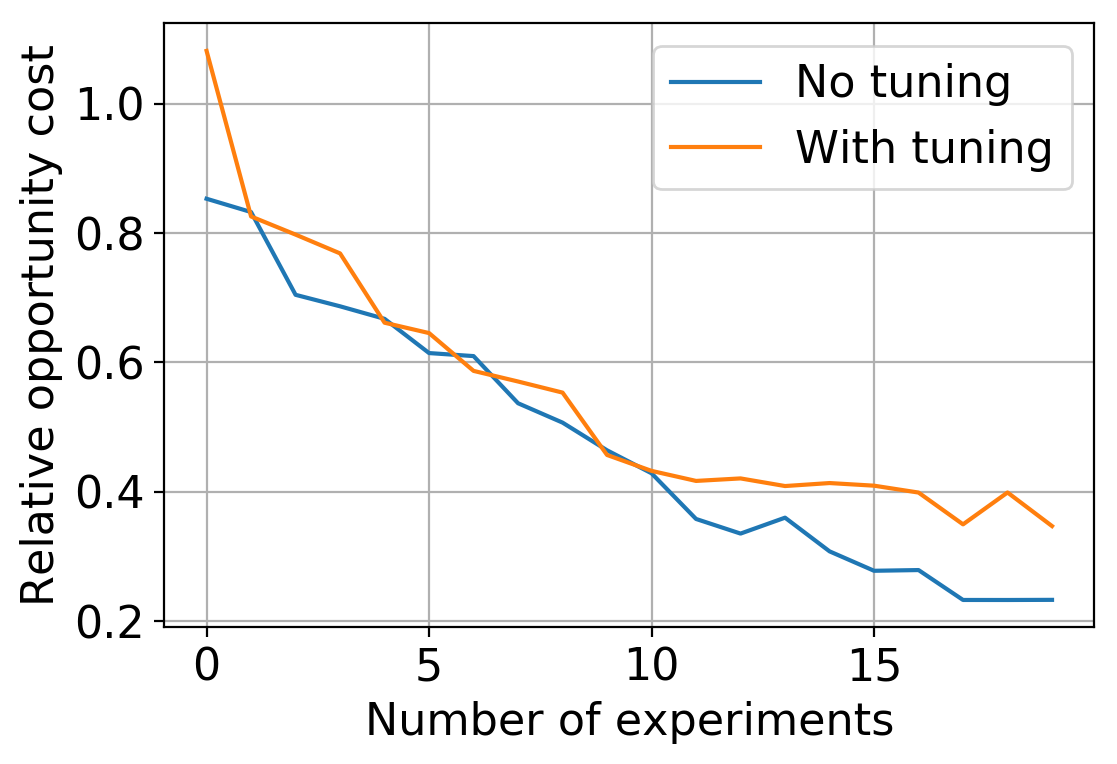

In [110]:
plt.plot(median_oc_0)
plt.plot(median_oc_10)
plt.grid()
plt.xlabel('Number of experiments')
plt.ylabel('Relative opportunity cost')
plt.legend(['No tuning', 'With tuning'])

Text(0, 0.5, 'Estimated length scale')

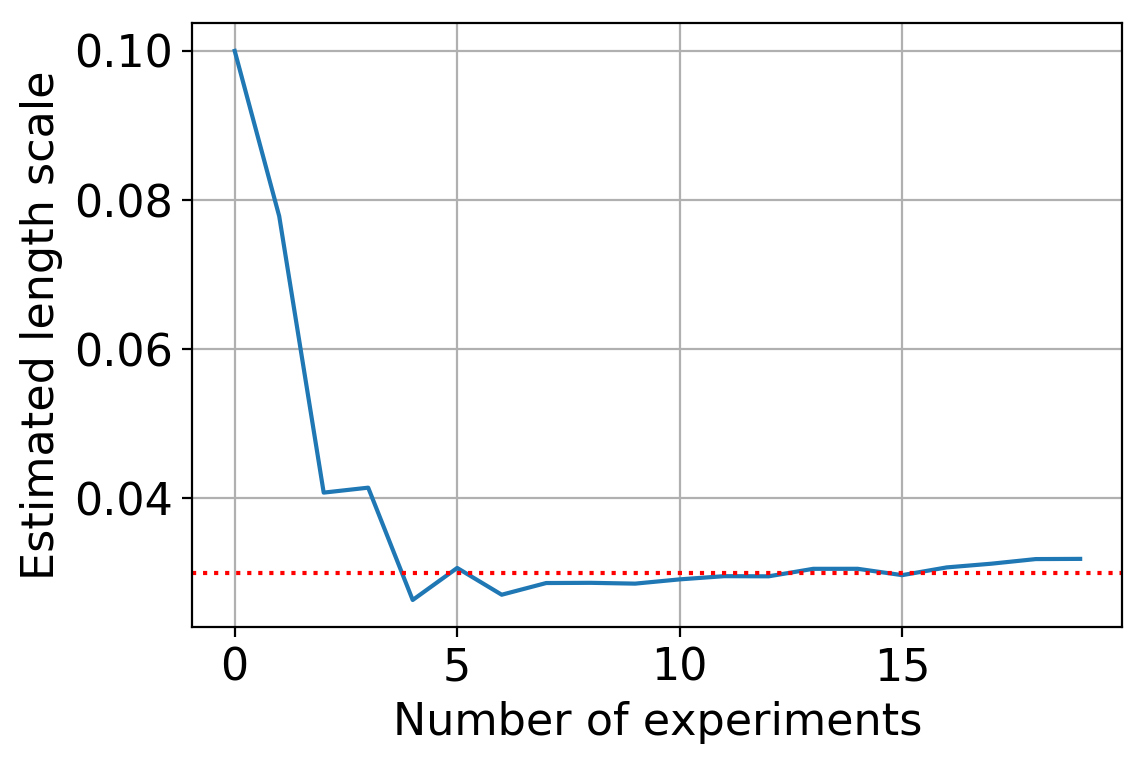

In [92]:
length_scale = np.zeros([NUM_SIMS, NUM_EXPS])

for i in range(NUM_SIMS):
    length_scale[i, 0] = 0.1
    for j in range(1, NUM_EXPS):
        length_scale[i,j] = sim_res_10[i].sim_states[j]['modeled_state'].current_beliefs.gpr.kernel_.get_params()['k2'].length_scale
        
median_ls = np.median(length_scale, axis = 0)
plt.plot(median_ls)
lim = plt.xlim()
plt.plot(lim, [0.03, 0.03], linestyle=':', color = 'r')
plt.xlim(lim)
plt.grid()
plt.xlabel('Number of experiments')
plt.ylabel('Estimated length scale')

# Example 2: Study the effect of `include_noise_variance` (EI Policy).

In [99]:
pi_false = EIPolicy(optimizer, obs_model, include_noise_var = False)
pi_true = EIPolicy(optimizer, obs_model, include_noise_var = True)

ground_truth_states = generate_bayesian_optimization_states(S_0, NUM_SIMS)
simulator = Simulator(ground_truth_states, obs_model)

In [100]:
sim_res_false = simulator.simulate(S_0, obs_model, pi_false) 
sim_res_true = simulator.simulate(S_0, obs_model, pi_true) 

In [103]:
# Find the maximum of all the ground truth states
y_star = []
for S in ground_truth_states:
    f = lambda x: obs_model.mean(S, x)
    y_star.append(optimizer.optimize(f)[0])
    
# calculate oc values      
oc_false = calculate_oc(sim_res_false, optimizer, indices = range(0, NUM_EXPS), y_star = y_star)
oc_true = calculate_oc(sim_res_true, optimizer, indices = range(0, NUM_EXPS), y_star = y_star)
median_oc_false = np.median(oc_false, axis = 0)
median_oc_true = np.median(oc_true, axis = 0)

In [105]:
plt.plot(median_oc_false)
plt.plot(median_oc_true)
plt.grid()
plt.xlabel('Number of experiments')
plt.ylabel('Relative opportunity cost')
plt.legend(['No noise modeling', 'With noise modeling'])

# Example 3: Study the impact of a non-informative vs. informative prior

Often, when specifying prior beliefs, we use a uninformative prior consisting of a constant mean function, and large initial uncertainty. If we can get a more informative prior, we may have to do less experiments in order to "relearn" features of the ground truth response function.

Below, we examine simulation results using both a non-informative and informative prior. To do this, we sample a function $f \sim B_0$, and use this function to generate several data points. 

In [43]:
NUM_DATA = 4

# Generate data by sampling a specific function
f = B_0.sample()
X = [ A.sample() for _ in range(NUM_DATA) ]
data = np.zeros([NUM_DATA, 3])
for i, x in enumerate(X):
    data[i, 0] = x
    data[i, 1] = f(x) + np.random.normal(0, 1)
    data[i, 2] = 1**2

From this, we generate a posterior belief, called $B_\text{informative}$, which incorporates the sampled data points. We'll treat this as the "informative prior". We build an initial, informative state with this belief as its initial belief.

In [44]:
# Form new, informative beliefs
B_informative = GaussianProcessBeliefs(0, SIGMA_0**2, [0.1], num_hyperparameter_fits = 10, data = data)
S_informative = BayesianOptimizationState(B_informative, 0, NUM_EXPS, A, optimizer)

Let's visualize the difference between the two beliefs below.

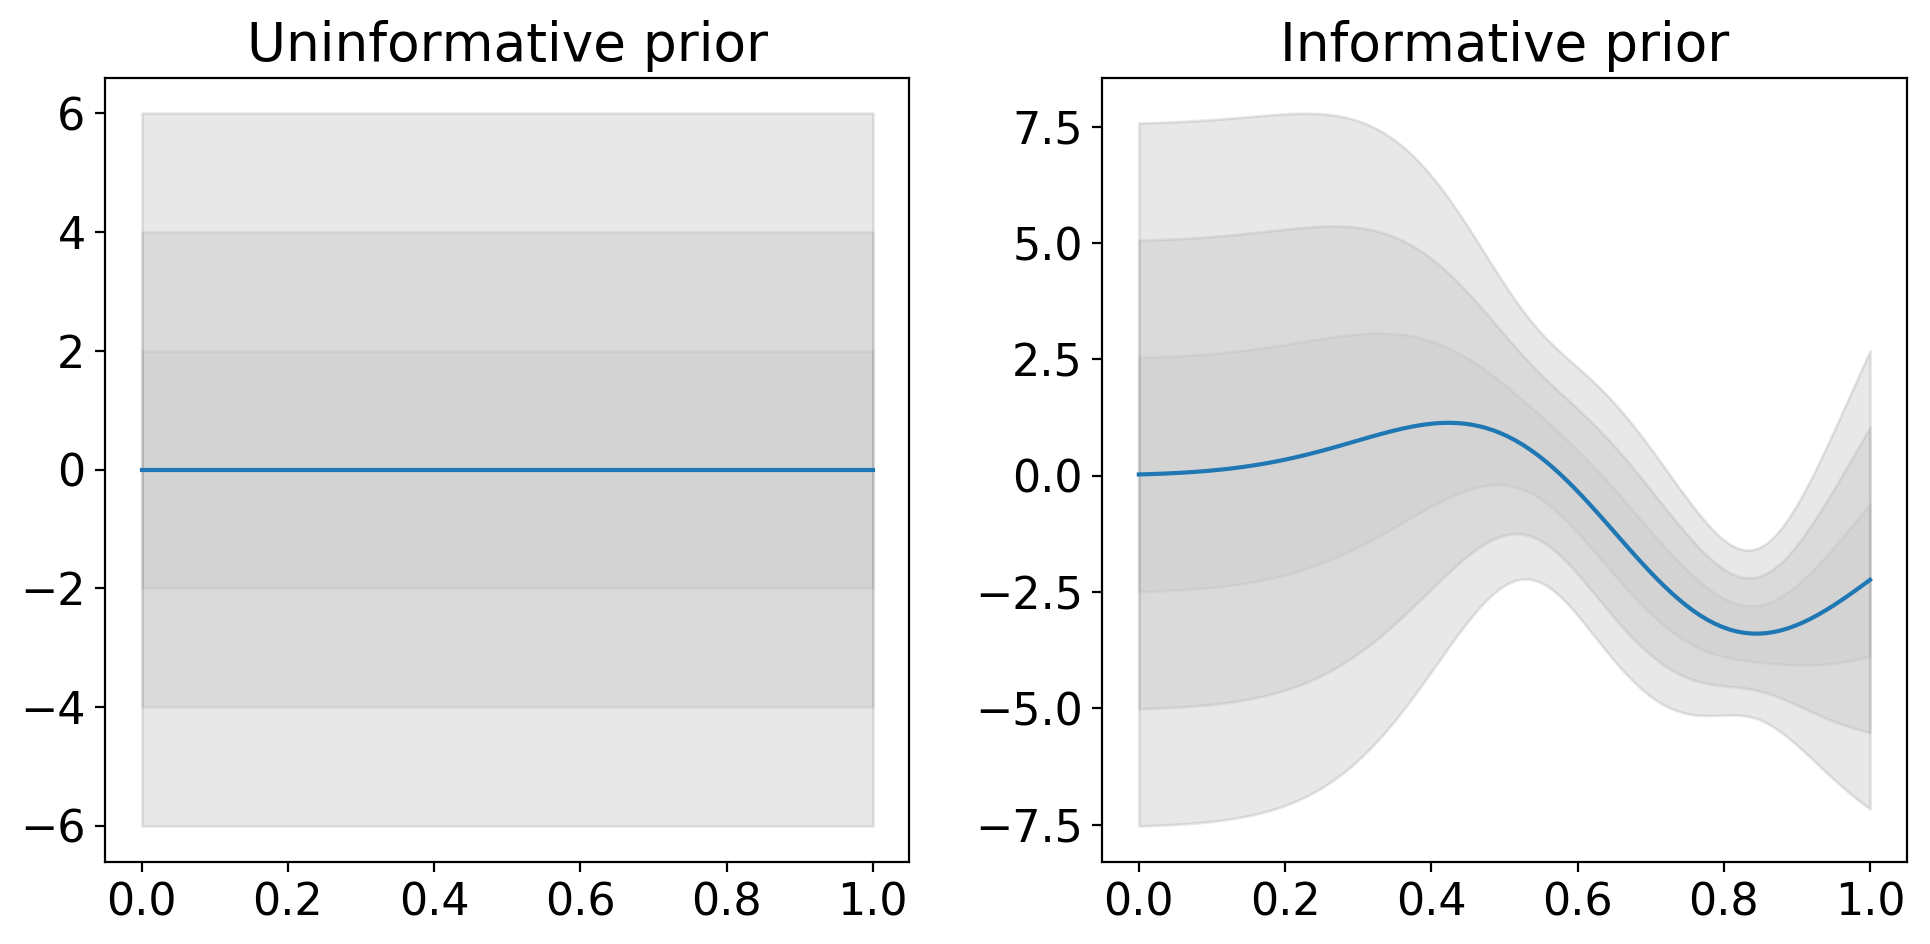

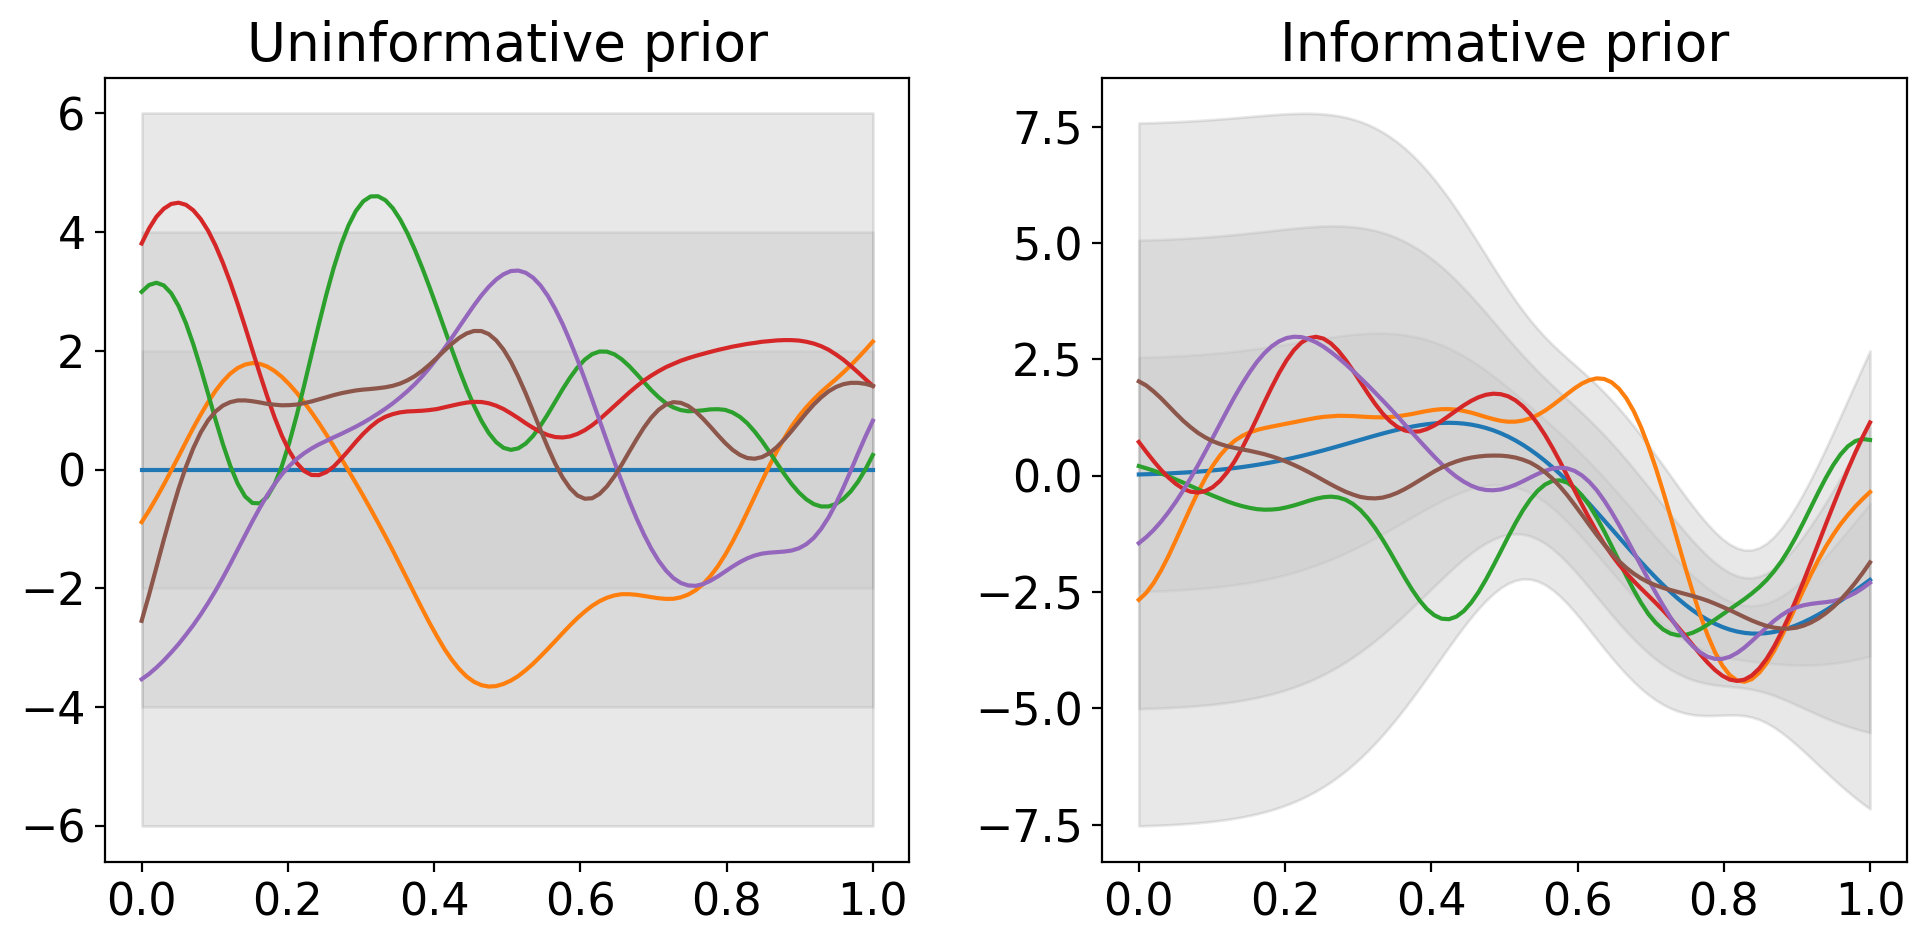

In [45]:
def plot_beliefs(S, obs_model, num_samples = 0):
    f = lambda x: obs_model.mean(S, x)
    sig = lambda x: np.sqrt(obs_model.covariance(S, x, x))
    
    x_plot = np.linspace(0, 1, 100)
    y_plot = np.array([f([x]) for x in x_plot])
    s_plot = np.array([sig([x]) for x in x_plot])
    
    plt.plot(x_plot, y_plot)
    for i in range(1, 4):
        plt.fill_between(x_plot, y_plot + i*s_plot, y_plot - i*s_plot, color = 'k', alpha = 0.03*i)
        
    for i in range(num_samples):
        ff = S.current_beliefs.sample()
        y_plot = np.array([ff([x]) for x in x_plot])
        plt.plot(x_plot, y_plot)


plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plot_beliefs(S_0, obs_model)
plt.title('Uninformative prior')
plt.subplot(1, 2, 2)
plot_beliefs(S_informative, obs_model)
plt.title('Informative prior')
plt.tight_layout()


plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plot_beliefs(S_0, obs_model, num_samples = 5)
plt.title('Uninformative prior')
plt.subplot(1, 2, 2)
plot_beliefs(S_informative, obs_model, num_samples = 5)
plt.title('Informative prior')
plt.tight_layout()

We'll run simulations with ground truths sampled from $B_\text{informative}$.

In [46]:
# Generate ground truth according to more specific prior
ground_truth_states = generate_bayesian_optimization_states(S_informative, NUM_SIMS)
simulator = Simulator(ground_truth_states, obs_model)

First, we run simulations starting from the uninformative prior state $S_0$.

In [47]:
# With uninformative prior
all_sim_res_uninformative = []
for pi in policies:
    print("Running policy: %s ... " % pi , end = "")
    start = timer() 
    sim_res = simulator.simulate(S_0, obs_model, pi) 
    all_sim_res_uninformative.append(sim_res)
    end = timer()
    print("done.\n\tElapsed time: %f seconds"% (end - start))

Running policy: EI ... done.
	Elapsed time: 255.125291 seconds
Running policy: UCB_001.41 ... done.
	Elapsed time: 186.078633 seconds
Running policy: XPLR ... done.
	Elapsed time: 132.253345 seconds
Running policy: XPLT ... done.
	Elapsed time: 137.061134 seconds


Next we run simulations starting from the informative prior state $S_\text{informative}$.

In [48]:
# With informative prior
all_sim_res_informative = []
for pi in policies:
    print("Running policy: %s ... " % pi , end = "")
    start = timer() 
    sim_res = simulator.simulate(S_informative, obs_model, pi) 
    all_sim_res_informative.append(sim_res)
    end = timer()
    print("done.\n\tElapsed time: %f seconds"% (end - start))

Running policy: EI ... done.
	Elapsed time: 263.218788 seconds
Running policy: UCB_001.41 ... done.
	Elapsed time: 190.827502 seconds
Running policy: XPLR ... done.
	Elapsed time: 133.286531 seconds
Running policy: XPLT ... done.
	Elapsed time: 136.307853 seconds


Now we calculate the OC for both sets of simulations.

In [49]:
# Find the maximum of all the ground truth states
y_star = []
for S_star in ground_truth_states:
    f = lambda x: obs_model.mean(S_star, x)
    y_star.append(optimizer.optimize(f)[0])
    
# calculate oc values      
all_oc_uninformative = np.zeros([len(policies), NUM_SIMS, NUM_EXPS])  
for i, sim_res in enumerate(all_sim_res_uninformative):
    all_oc_uninformative[i, :, :] = calculate_oc(sim_res, optimizer, indices = range(0, NUM_EXPS), y_star = y_star)   
median_oc_uninformative = np .median(all_oc_uninformative, axis = 1)
 
all_oc_informative = np.zeros([len(policies), NUM_SIMS, NUM_EXPS])  
for i, sim_res in enumerate(all_sim_res_informative):
    all_oc_informative[i, :, :] = calculate_oc(sim_res, optimizer, indices = range(0, NUM_EXPS), y_star = y_star)   
median_oc_informative = np.median(all_oc_informative, axis = 1)

Finally, we plot the results, plotting the OC curves for the informative prior in dashed lines.

Text(0, 0.5, 'Relative opportunity cost')

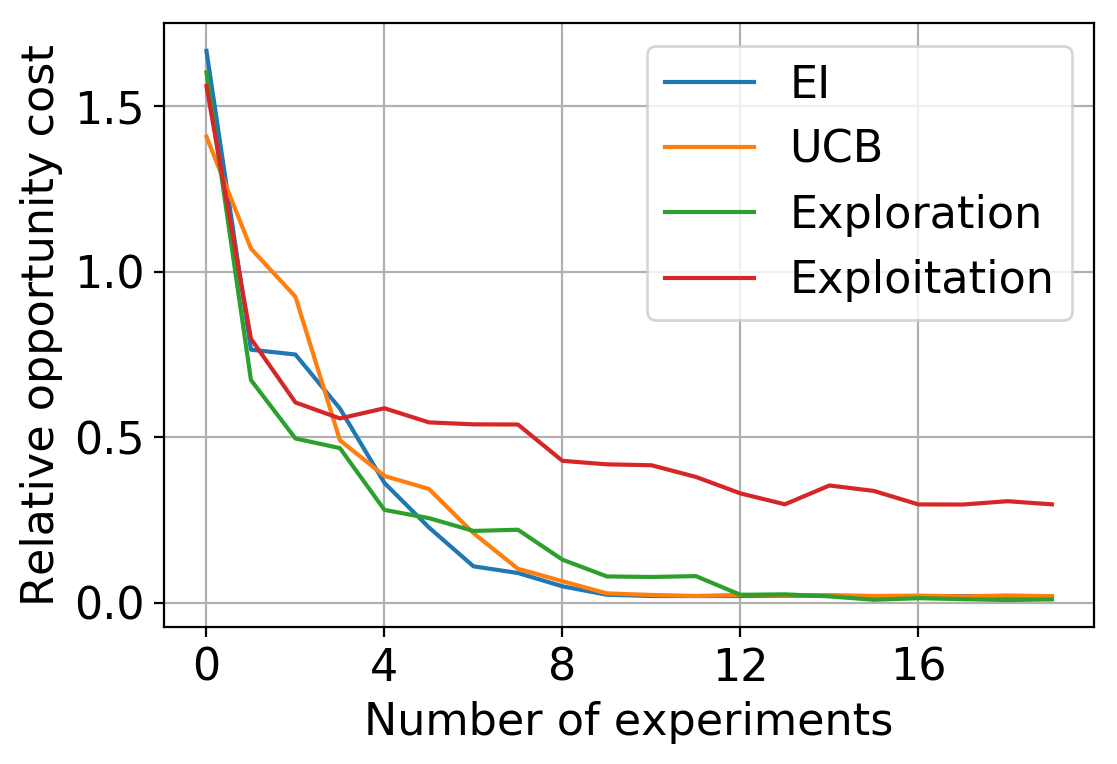

In [50]:
# Plot the uninformative OC curves
plt.plot(median_oc_uninformative.T)
plt.grid()
plt.legend(['EI', 'UCB', 'Exploration', 'Exploitation'])
plt.xlabel('Number of experiments')
plt.xticks(range(0, NUM_EXPS, 4), range(0, NUM_EXPS, 4))
plt.ylabel('Relative opportunity cost')

Text(0, 0.5, 'Relative opportunity cost')

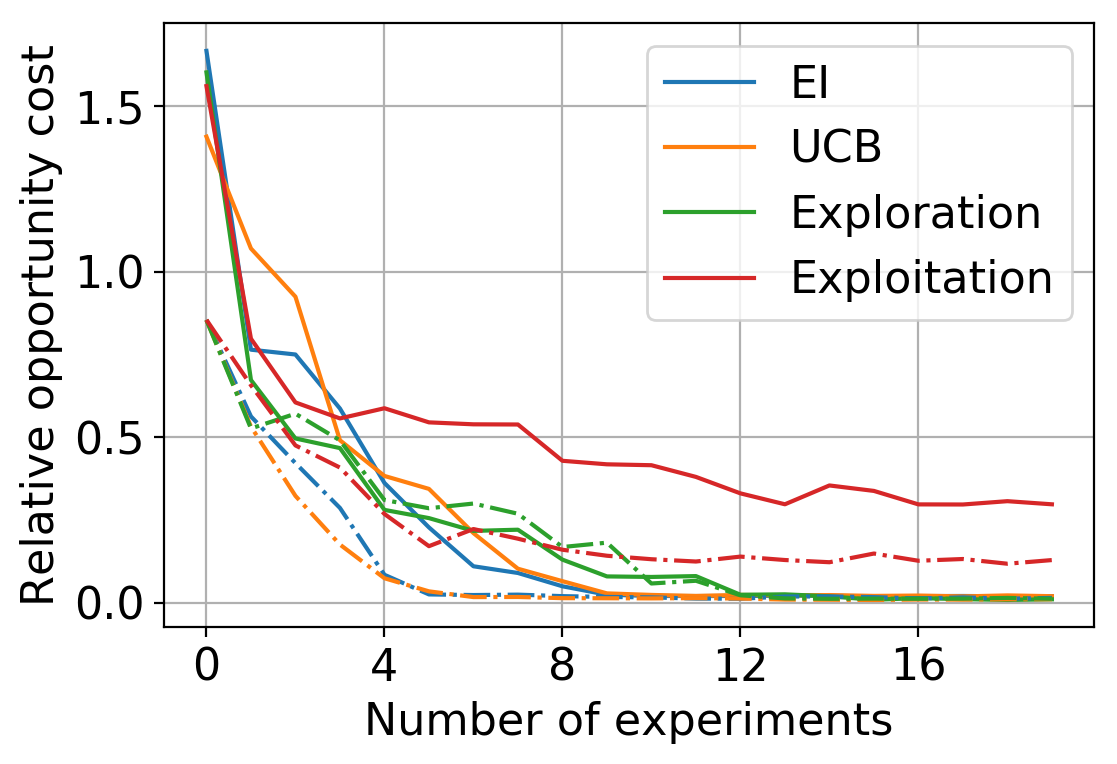

In [51]:
# Plot the uninformative OC curves
plt.plot(median_oc_uninformative.T)

# Plot the informative OC curves
plt.gca().set_prop_cycle(None)
plt.plot(median_oc_informative.T, linestyle='-.')

plt.grid()
plt.legend(['EI', 'UCB', 'Exploration', 'Exploitation'])
plt.xlabel('Number of experiments')
plt.xticks(range(0, NUM_EXPS, 4), range(0, NUM_EXPS, 4))
plt.ylabel('Relative opportunity cost')